In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch

from sklearn.cluster import KMeans

In [2]:
#trop_dbh = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'
wytham_ss_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ss_dbh.csv'
wytham_ms_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ms_dbh.csv'

wytham_qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"



In [3]:
wytham_ss_dbh = pd.read_csv(wytham_ss_dbh_path, index_col = [0])
wytham_ss_dbh['TLS_ID'] = wytham_ss_dbh['TLS_ID'].astype(str)

wytham_ms_dbh = pd.read_csv(wytham_ms_dbh_path, index_col = [0])
wytham_ms_dbh['TLS_ID'] = wytham_ms_dbh['TLS_ID'].astype(str)



wytham_ms_dbh = wytham_ms_dbh[wytham_ms_dbh['dbhadj'] > 0.1]

wytham_dbh = pd.concat([wytham_ss_dbh, wytham_ms_dbh])




In [4]:
wytham_dbh

,TLS_ID,dbh_hgt,dbh13,dbhadj,stems
0,1623,1.3,0.200199,0.200199,1
1,1179,1.3,0.362163,0.362163,1
2,2316,1.3,0.118219,0.118219,1
3,1384,1.3,0.199403,0.199403,1
4,9096,1.3,0.157539,0.157539,1
...,...,...,...,...,...
286,8113a,0.8,4.087244,0.158505,1
287,8406a,1.3,0.193180,0.193180,1
288,5a,1.5,0.465283,0.450170,1
289,8099c,1.3,0.107774,0.107774,1


In [5]:
wytham_qsm = pd.read_csv(wytham_qsm_path)


wytham_qsm = wytham_qsm[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


wytham_qsm['TLS_ID'] = wytham_qsm['TLS_ID'].astype(str)


#wytham_ss = wytham_ss_dbh.merge(wytham_qsm, on ='TLS_ID')
#wytham_ms = wytham_ms_dbh.merge(wytham_qsm, on ='TLS_ID')

wytham = wytham_dbh.merge(wytham_qsm, on ='TLS_ID')

In [6]:
wytham

,TLS_ID,dbh_hgt,dbh13,dbhadj,stems,stemlocx_[m],stemlocy_[m],DBH_TLS_[m],Hgt_pts_[m],VerticalCrownProjectedArea_pts_[m2],Vol_QSM_avg_[m3],Vol_QSM_D0_25mm_avg_[m3],Vol_QSM_D25_50mm_avg_[m3],Vol_QSM_D50_75mm_avg_[m3],Vol_QSM_D75_100mm_avg_[m3],Vol_QSM_D100_200mm_avg_[m3],Vol_QSM_D200_500mm_avg_[m3],Vol_QSM_D500_1000mm_avg_[m3],Vol_QSM_D1000mm_avg_[m3]
0,1623,1.3,0.200199,0.200199,1,110.306410,160.139205,0.166835,17.793612,7.856278,0.29930,0.012391,0.046016,0.028089,0.022503,0.190420,0.000000,0.000000,0.0
1,1179,1.3,0.362163,0.362163,1,87.160407,198.975028,0.218800,20.527044,11.785311,0.56040,0.025567,0.108023,0.050840,0.012992,0.250562,0.112448,0.000000,0.0
2,2316,1.3,0.118219,0.118219,1,37.438642,104.223540,0.105306,3.455709,0.080840,0.02564,0.000041,0.000272,0.000342,0.010291,0.014683,0.000000,0.000000,0.0
3,1384,1.3,0.199403,0.199403,1,26.342215,126.120809,0.166352,13.854225,24.175029,0.34330,0.025936,0.090311,0.022800,0.011619,0.192744,0.000000,0.000000,0.0
4,9096,1.3,0.157539,0.157539,1,34.613703,149.252665,0.137708,14.451563,18.630160,0.25590,0.041416,0.099663,0.010168,0.019781,0.084797,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,8113a,0.8,4.087244,0.158505,1,104.494836,187.769118,0.084250,4.749625,21.632701,0.07975,0.019113,0.042539,0.008437,0.009588,0.000083,0.000000,0.000000,0.0
792,8406a,1.3,0.193180,0.193180,1,14.429353,185.076443,0.163493,12.579003,9.787294,0.25170,0.017091,0.063812,0.028356,0.016258,0.123275,0.002922,0.000000,0.0
793,5a,1.5,0.465283,0.450170,1,93.223968,162.529665,0.438548,21.334519,53.797789,2.71880,0.118078,0.567053,0.331349,0.145143,0.221865,1.246036,0.089324,0.0
794,8099c,1.3,0.107774,0.107774,1,51.540298,185.754815,0.058550,7.398412,4.019764,0.02320,0.004257,0.008850,0.010090,0.000000,0.000000,0.000000,0.000000,0.0


Text(0, 0.5, 'DBH from TLS')

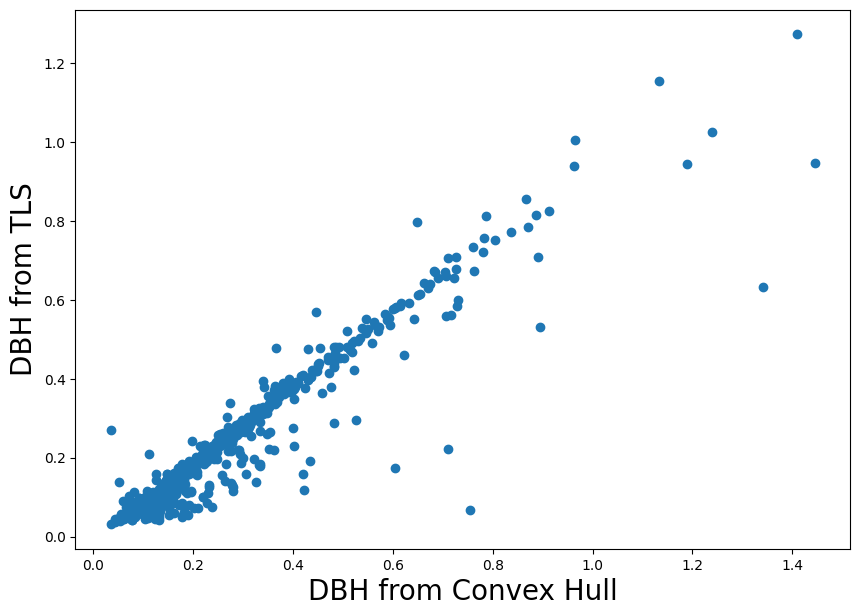

In [7]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

#smalltrees = treedata[treedata['DBH_CV']<4]

plt.figure(figsize=(10,7))
plt.scatter(wytham['dbhadj'], wytham['DBH_TLS_[m]'])
plt.xlabel('DBH from Convex Hull', fontsize=20)
plt.ylabel('DBH from TLS', fontsize=20)


In [8]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(wytham['dbhadj'])

# Remove the labels from the features
# axis 1 refers to the columns
features = wytham.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
wytham

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'])
plt.xlabel('Predictions (DBH)', fontsize=20)
plt.ylabel('Measured Values (DBH)', fontsize=20)



In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'])
plt.xlabel('Measured Values (DBH)', fontsize=20)
plt.ylabel('Errors', fontsize=20)

In [ ]:
# merge rf results back with original dataset
#https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe
# TODO: in final - re-run model on full dataset and split into training vs testing

df_out = pd.merge(treedata,rf_results[['mape', 'errors', 'predictions']],how = 'left',left_index = True, right_index = True)

#rf_results.shape
df_out.head(150)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_out['verts'], df_out['errors'])
plt.xlabel('DBH Verts', fontsize=20)
plt.ylabel('Errors', fontsize=20)